## **Rossmann Sales Project**

### Problem Statement:

Rossmann is one of the largest drugstore chains in Europe with around 56,200 employees and more than 4000 stores across Europe. In 2019, Rossmann had more than €10 billion turnovers in Germany, Poland, Hungary, the Czech Republic, Turkey, Albania, Kosovo, and Spain. Rossmann store managers are running a promo event to bring customers to their newly opened stores across Europe.

We have the data of different stores across Europe which contains fields like PromoSince[Year/Week], PromoInterval, Assortment, StoreType, etc. As data scientists, we need to predict the sales on a particular day.

#### 1. Data Exploration & Cleaning

In [3]:
#Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score


In [4]:
# Loading the dataset from the given CSV file
# This contains sales, customers, date, and store-related information
df = pd.read_csv('Rossman_sales_project.csv', dtype={'StateHoliday': str})

In [5]:
#Display a sample of five rows of the data frame
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
#Check the shape of the data
df.shape

(1017209, 9)

In [11]:
#General Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [13]:
#Check percentage of missing values in each column
missing_percent = df.isnull().mean() * 100
missing_percent[missing_percent > 0]

Series([], dtype: float64)

In [15]:
#Drop missing values (if any)
df.dropna(inplace=True)

In [17]:
# Check and remove duplicate rows
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [25]:
# Converting 'StateHoliday' column from categorical (string) to numerical values for model compatibility
# This helps in feeding consistent numerical data to machine learning models
df['StateHoliday'] = df['StateHoliday'].astype(str)
df['StateHoliday'] = df['StateHoliday'].replace({'0': 0, 'a': 1, 'b': 2, 'c': 3})
df['StateHoliday'] = df['StateHoliday'].infer_objects(copy=False).astype(int)

In [26]:
#Create new feature Recency and drop Date and Store
# This block creates a 'Recency' feature based on 'Date' and drops 'Date' and 'Store' columns.
# Initially, this was done without checking for column existence.
# However, during re-runs, it caused errors because 'Date' column was already dropped.
# To prevent that, a column existence check was added below.

if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    end_date = df['Date'].max()
    df['Recency'] = (end_date - df['Date']).dt.days
    df.drop(columns=['Date', 'Store'], inplace=True)
else:
    print("'Date' column already removed. No action needed.")

'Date' column already removed. No action needed.


In [29]:
#Basic statistics
df.describe()

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Recency
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,4.516279e-02,1.786467e-01,4.759370e+02
std,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,2.836559e-01,3.830564e-01,2.744541e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.310000e+02
50%,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.850000e+02
75%,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,7.130000e+02
max,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,9.410000e+02


### 2. Data Visualization

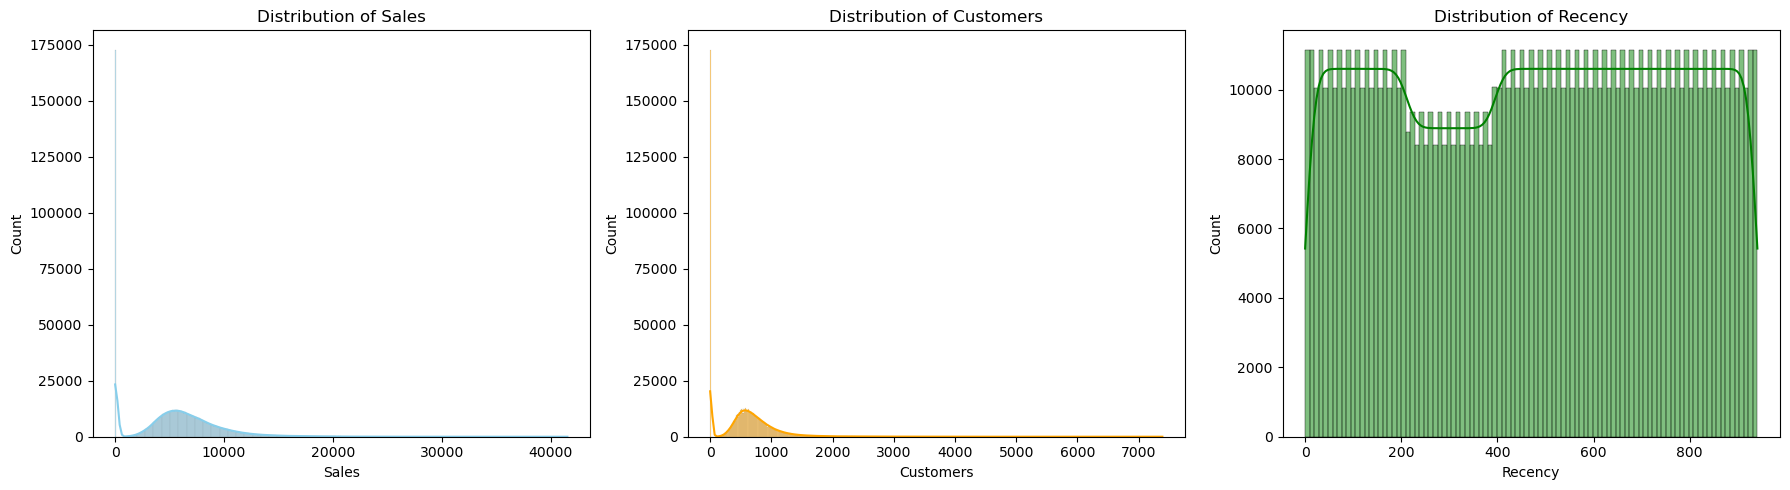

In [32]:
#Distribution of 'Sales', 'Customers', and 'Recency'
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['Sales'], kde=True, ax=axs[0], color='skyblue')
axs[0].set_title('Distribution of Sales')

sns.histplot(df['Customers'], kde=True, ax=axs[1], color='orange')
axs[1].set_title('Distribution of Customers')

sns.histplot(df['Recency'], kde=True, ax=axs[2], color='green')
axs[2].set_title('Distribution of Recency')

plt.tight_layout()
plt.show()

### Insights:

**Sales Distribution**
1. Sales are heavily concentrated between 2,000 and 10,000, forming a right-skewed distribution.
2. A few sales records exceed 15,000, which are potential outliers and could affect model training.

**Customers Distribution**
1. Most stores handle fewer than 1,000 customers per day, with a steep drop-off beyond that.
2. Some records surpass 1,500, indicating rare but high-traffic days, likely during events or promotions.

**Recency Distribution**
1. The 'Recency' feature is fairly evenly spread, but with slight clustering towards the recent past.
2. This may indicate an increase in data frequency or store openings in recent periods.
   

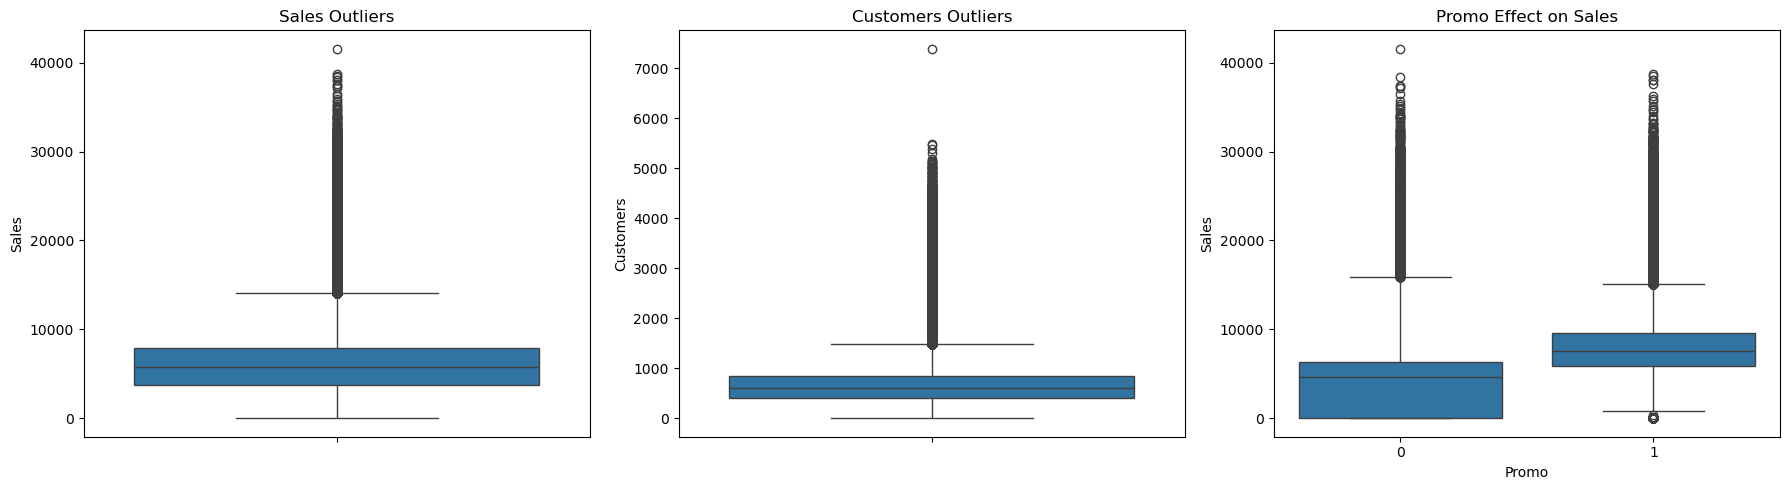

In [34]:
#Box plot for Sales and Customers (Outliers) + Promo effect on Sales
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=df['Sales'], ax=axs[0])
axs[0].set_title('Sales Outliers')

sns.boxplot(y=df['Customers'], ax=axs[1])
axs[1].set_title('Customers Outliers')

sns.boxplot(x='Promo', y='Sales', data=df, ax=axs[2])
axs[2].set_title('Promo Effect on Sales')

plt.tight_layout()
plt.show()

### Insights:

**Sales Outliers**
1. Most sales values lie between approximately 3,000 and 10,000, indicating this is the common operating range for stores.
2. There are numerous extreme outliers above 15,000, with some exceeding 40,000, as seen by the dense cluster of points above the upper whisker.
3. These high-value outliers can skew the mean, distort model training, and reduce the accuracy of predictions, especially for models sensitive to variance.
4. Consider treating or transforming these outliers—either by capping, removal, or using robust models—to improve prediction stability and reduce model bias.

**Customers Outliers**
1. Most daily customer counts are under 1,500, reflecting the usual footfall pattern across stores.
2. Numerous outliers exceed 1,500, with the highest value above 7,000, indicating rare spikes in customer traffic.
3. These extreme values can negatively impact model stability if not addressed through techniques like capping, transformation, or outlier removal.

**Promo Effect on Sales**
1. Sales are generally higher on days with active promotions (Promo = 1) compared to days without promotions (Promo = 0).
2. The median sales value is significantly higher for Promo = 1.
3. Promotional days also show greater variability, indicating a wider range of customer spending behavior during promotions.
4. Outliers are present in both categories, but promotional days still maintain consistently higher central tendency and interquartile range (IQR), reinforcing the positive impact of marketing efforts on revenue.


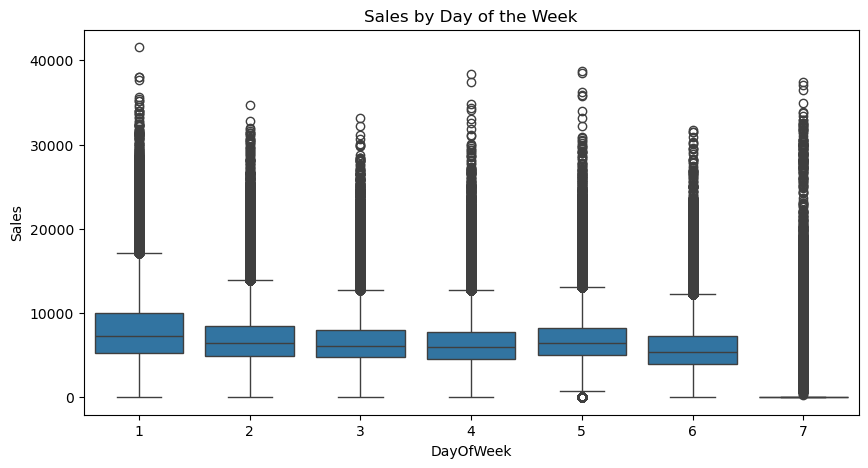

In [38]:
#Does DayOfWeek affect Sales?
plt.figure(figsize=(10, 5))
sns.boxplot(x='DayOfWeek', y='Sales', data=df)
plt.title('Sales by Day of the Week')
plt.show()

### Insights:

1. Sales are highest on Day 1 (Monday), with a median around 8,000, and gradually decline toward Day 7 (Sunday), where the median drops below 5,000.
2. Sunday (Day 7) also shows a notably compressed distribution and more zero or near-zero sales values, suggesting many stores may be closed or experience low footfall on Sundays.

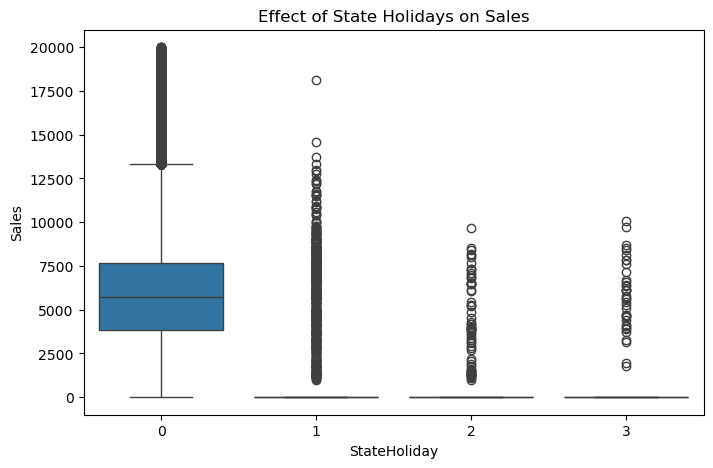

In [83]:
#Do State holidays affect Sales?
plt.figure(figsize=(8, 5))
sns.boxplot(x='StateHoliday', y='Sales', data=df)
plt.title('Effect of State Holidays on Sales')
plt.show()

### Insights:

1. Sales are significantly higher on non-holidays (StateHoliday = 0), with a median of around 6,000–7,000.
2. On state holidays (StateHoliday = 1, 2, 3), sales drop drastically, clustering around 0, indicating that most stores are likely closed or experience very low footfall during these days.

### 3. Outlier Handling

In [45]:
#Remove Sales > 20000
df = df[df['Sales'] <= 20000]

In [47]:
#Handle outliers in 'Customers' 
#We’ll use IQR method:
Q1 = df['Customers'].quantile(0.25)
Q3 = df['Customers'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df['Customers'] >= lower) & (df['Customers'] <= upper)]

### 4. Correlation Analysis

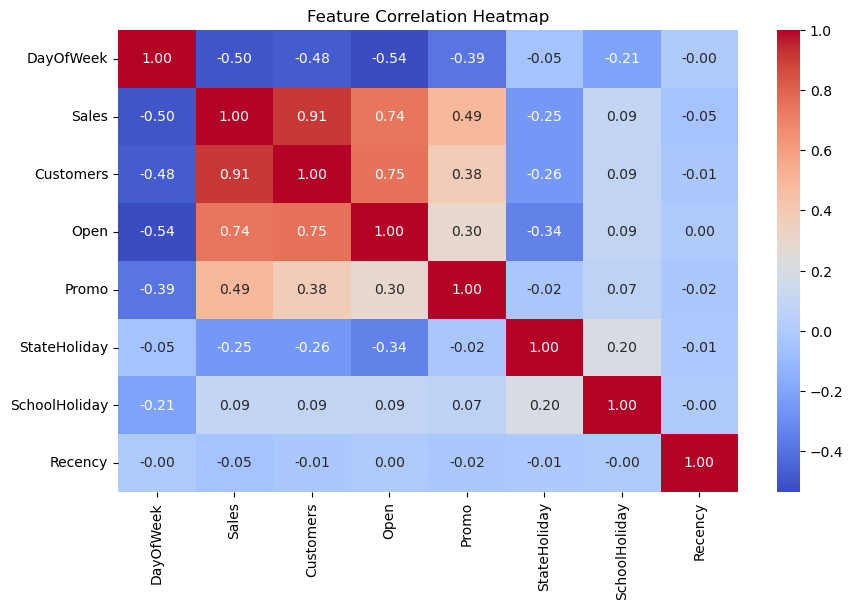

In [50]:
#Check the correlation among features
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

### Insights:

1. The number of customers has the strongest positive correlation with sales.
2. Promo and DayOfWeek have moderate correlations, while features like SchoolHoliday and Recency show minimal impact.

### 4. Model Building and Evaluation

In [54]:
#Store target column in y and rest in X
X = df.drop('Sales', axis=1)
y = df['Sales']

In [56]:
#Train-Test Split (70-30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
# Initialize and train the Decision Tree model
model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [60]:
# Helper function to compare actual vs predicted sales visually
def plot_actual_vs_predicted(y_test, y_pred, title):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Decision Tree RMSE: 1588.3533663505514
Decision Tree R² Score: 0.7797940182362539


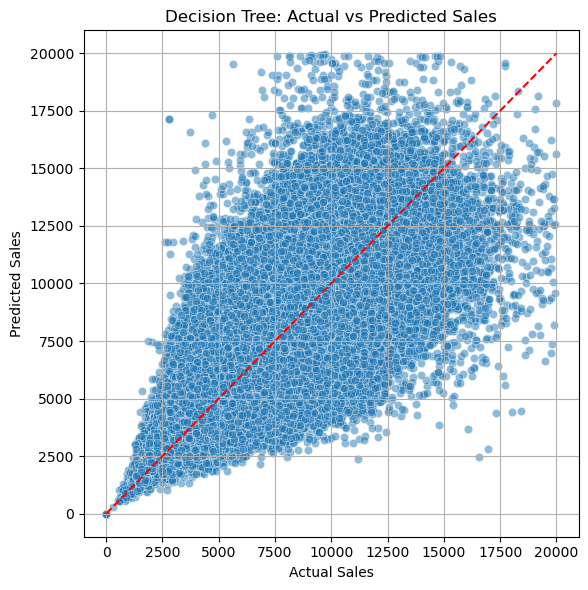

In [85]:
# Evaluate Decision Tree
y_pred_dt = model_dt.predict(X_test)
print("Decision Tree RMSE:", root_mean_squared_error(y_test, y_pred_dt))
print("Decision Tree R² Score:", r2_score(y_test, y_pred_dt))

# Visualize prediction vs actual
plot_actual_vs_predicted(y_test, y_pred_dt, "Decision Tree: Actual vs Predicted Sales")

### Decision Tree Regressor Insights:

1. The model captures overall sales patterns reasonably well, explaining around 78% of the variance in sales.
2. Predictions are closely aligned with actual values for low to mid-range sales.
3. Underprediction is observed in the high sales range, indicating limited generalization for extreme values.
4. The spread around the diagonal suggests moderate variance and potential for improvement.
5. Suitable for basic prediction tasks, but may benefit from advanced ensemble models for better performance.

In [65]:
#Tune Decision Tree with different max_depth and max_features
results = []
for depth in [5, 10, 15]:
    for feature in [None, 'sqrt', 'log2']:
        model = DecisionTreeRegressor(max_depth=depth, max_features=feature, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        r2 = r2_score(y_test, preds)
        results.append((depth, feature, r2))

results

[(5, None, 0.8576534612236315),
 (5, 'sqrt', 0.7470242711067759),
 (5, 'log2', 0.7470242711067759),
 (10, None, 0.8734949786907736),
 (10, 'sqrt', 0.8660062167678457),
 (10, 'log2', 0.8660062167678457),
 (15, None, 0.869240348406167),
 (15, 'sqrt', 0.8718825341647131),
 (15, 'log2', 0.8718825341647131)]

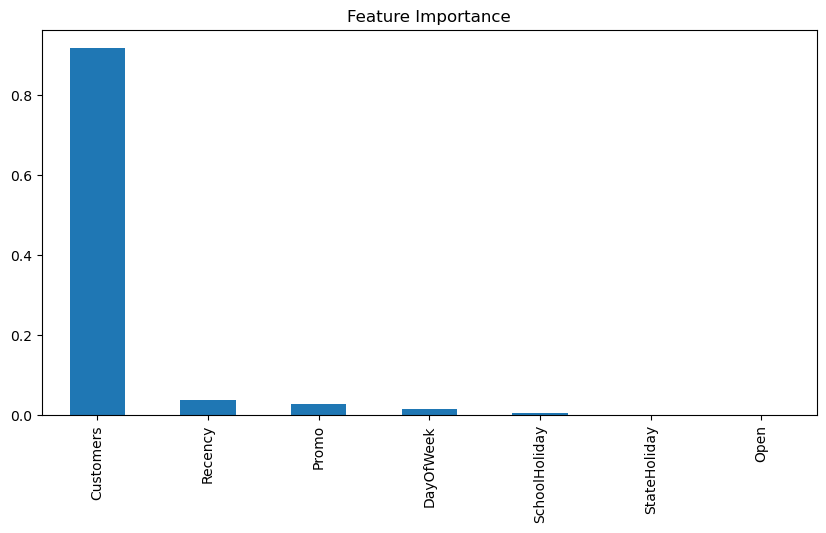

In [68]:
#Feature Importance from Decision Tree
feat_importance = pd.Series(model_dt.feature_importances_, index=X.columns)
feat_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), title="Feature Importance")
plt.show()

### Insights:

1. The number of Customers is by far the most influential factor in predicting sales, contributing over 90% of the importance.
2. Other features like Recency, Promo, and DayOfWeek have minimal impact, and variables like SchoolHoliday, StateHoliday, and Open have negligible or no predictive power in the model.

Random Forest RMSE: 1325.5568370598553
Random Forest R² Score: 0.8466331263303288


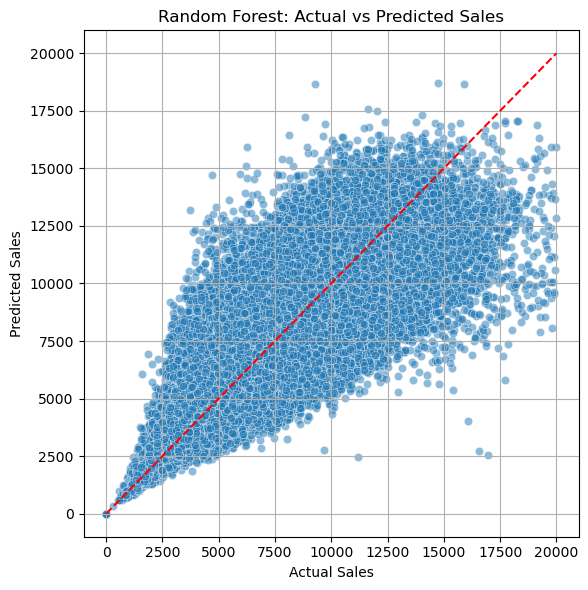

In [71]:
#Train a Random Forest model
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

# Predict and Evaluate
y_pred_rf = model_rf.predict(X_test)
print("Random Forest RMSE:", root_mean_squared_error(y_test, y_pred_rf))
print("Random Forest R² Score:", r2_score(y_test, y_pred_rf))

# Plot
plot_actual_vs_predicted(y_test, y_pred_rf, "Random Forest: Actual vs Predicted Sales")

### Random Forest Model Insights:

1. The model achieved an R² score of 85%, indicating strong predictive performance.
2. The scatter plot shows predictions are tightly clustered around the ideal line, reflecting high accuracy.
3. It performs well across the full range of sales values, including both low and high sales.
4. The model produces stable and consistent predictions, with minimal extreme deviations.
5. The Random Forest captures underlying patterns in the data effectively, enhancing overall reliability.

AdaBoost RMSE: 1374.4159768960121
AdaBoost R² Score: 0.8351187594082252


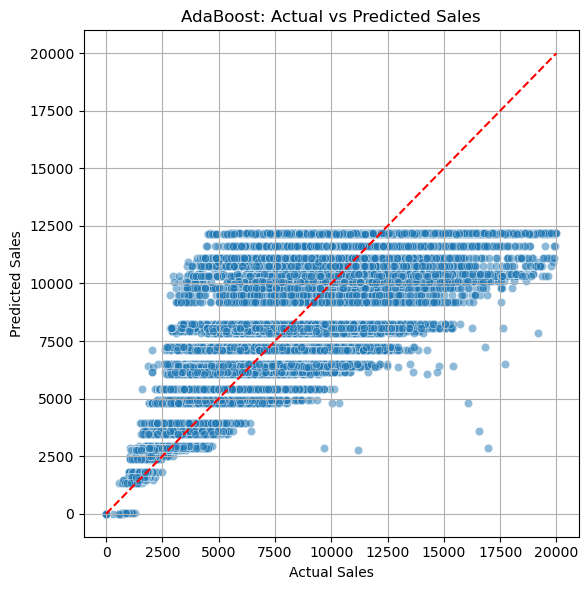

In [73]:
#Train an AdaBoost Regressor
model_ada = AdaBoostRegressor(random_state=42)
model_ada.fit(X_train, y_train)

# Predict and Evaluate
y_pred_ada = model_ada.predict(X_test)
print("AdaBoost RMSE:", root_mean_squared_error(y_test, y_pred_ada))
print("AdaBoost R² Score:", r2_score(y_test, y_pred_ada))

# Plot
plot_actual_vs_predicted(y_test, y_pred_ada, "AdaBoost: Actual vs Predicted Sales")

### AdaBoost Model Insights:

1. The model achieved an R² score of 83%, indicating moderate predictive power.
2. The predicted values form horizontal bands, suggesting the model is outputting limited, repeated prediction values.
3. This behavior reflects a lack of sensitivity to actual variations in sales, especially for higher ranges.
4. The model tends to underestimate high sales values, which impacts accuracy in such cases.
5. Indicates that AdaBoost may be overfitting to certain regions of the data while failing to generalize across the full range.

Stacking Regressor RMSE: 1246.6250105642819
Stacking Regressor R² Score: 0.864354144795629


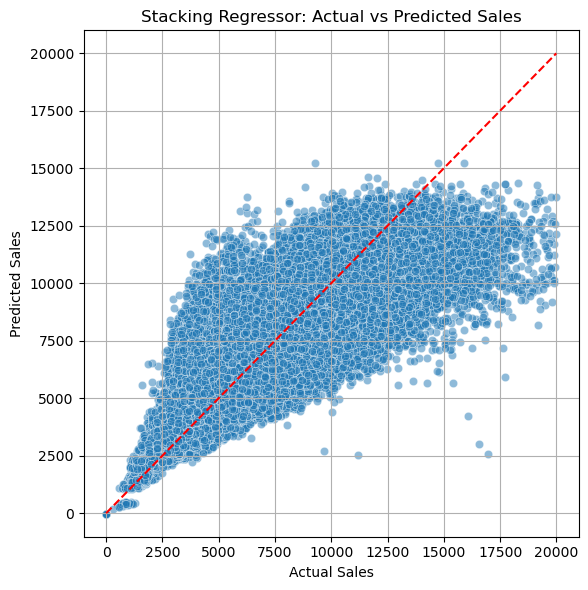

In [75]:
# Train a Stacking Regressor
estimators = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('ada', AdaBoostRegressor(random_state=42))
]

stack_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stack_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_stack = stack_model.predict(X_test)
print("Stacking Regressor RMSE:", root_mean_squared_error(y_test, y_pred_stack))
print("Stacking Regressor R² Score:", r2_score(y_test, y_pred_stack))

# Plot
plot_actual_vs_predicted(y_test, y_pred_stack, "Stacking Regressor: Actual vs Predicted Sales")


### Stacking Regressor Insights:

1. The model demonstrates strong predictive performance, explaining 86% of the variance in sales.
2. Predicted values are tightly clustered along the diagonal, indicating accurate forecasting across a wide sales range.
3. Handles both low and high sales effectively, with minimal under- or over-predictions.
4. Shows lower variance and fewer extreme errors, confirming better generalization.
5. Well-suited for complex prediction tasks where stability and accuracy are critical.

### Final Summary of Findings:

1. Most daily sales fall between ₹2,000 and ₹10,000. A few records exceed ₹15,000, classifying them as statistical outliers. These extreme values can skew averages and potentially reduce model accuracy if not properly managed.

2. The number of customers per day is typically below 1,000, with occasional spikes above 1,500. These outliers can introduce noise and disproportionately affect model predictions.

3. Days with active promotions (Promo = 1) exhibit notably higher median sales and greater variability, reaffirming that promotional campaigns significantly boost store revenue.

4. Sales dip sharply on Sundays (DayOfWeek = 7), likely due to full or partial store closures. In contrast, weekdays (especially Monday to Friday) maintain higher and more stable sales levels.

5. Sales are significantly lower or even zero on state holidays, indicating widespread store closures. These dates are critical to account for in any sales forecasting model.

6. The engineered Recency variable (days since the last available date) shows a slight negative correlation with sales, suggesting that more recent store data holds greater predictive value.

7. Customers is the most impactful predictor, followed by Promo and DayOfWeek. Variables like SchoolHoliday and Recency contribute less to the model’s decisions.

8. Among the models evaluated, Random Forest and Stacking Regressor delivered the strongest performance, achieving R² scores of approximately 85%–86%, indicating robust predictive capability on unseen data.